# **COVID 19 Diagnosis System**

### **Importing the Libraries**

In [0]:
import tensorflow as tf
import pandas as pd
import random
from imutils import paths
from tensorflow.keras.applications import VGG16, VGG19
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import cv2
import os

### **Data Exploration**

In [60]:
#Loading the data about data
covid_data = pd.read_csv('metadata.csv')
covid_data.head()

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [61]:
covid_data[['finding','view','modality','location']]

,finding,view,modality,location
0,COVID-19,PA,X-ray,NaN
1,COVID-19,PA,X-ray,NaN
2,COVID-19,PA,X-ray,NaN
3,COVID-19,PA,X-ray,NaN
4,COVID-19,PA,X-ray,"Changhua Christian Hospital, Changhua City, Ta..."
...,...,...,...,...
141,COVID-19,AP Supine,X-ray,Italy
142,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
143,COVID-19,PA,X-ray,"The Royal Melbourne Hospital, Melbourne, Austr..."
144,COVID-19,AP,X-ray,NaN


### **Loading the image data**

Number of training images:  138


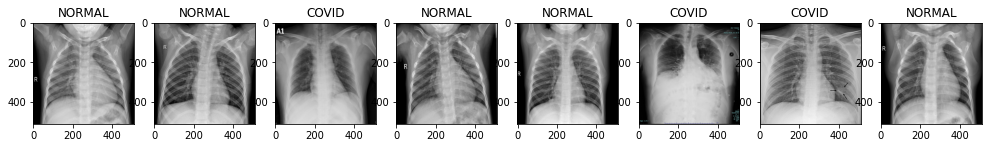

In [141]:
#List of files
path_list = list(paths.list_images('Dataset'))
X = []
Y = []


for path in path_list:
    # Set Class label
    y = path.split(os.path.sep)[-2]
    # change the color space of the image and reshape
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))

    # update the data and labels lists, respectively
    X.append(image)
    Y.append(y)

# Normalize images
X = np.array(X) / 255.0
Y = np.array(Y)

print('Number of training images: ', len(X))
# Plot example patient scan
W = 8
L = 1
fig, axes = plt.subplots(L, W, figsize = (17,17))
axes = axes.ravel() 
n = 138
for i in np.arange(0, W * L):
    index = np.random.randint(0, n)    
    axes[i].imshow( X[index] )
    axes[i].set_title(Y[index])


#one-hot encoding on the labels
lb = LabelBinarizer()
Y = lb.fit_transform(Y)
Y = tf.keras.utils.to_categorical(Y)

### **Splitting the data**

In [0]:
# split training and test data
(X_train, x_test, Y_train, y_test) = train_test_split(X, Y,
	test_size=0.20, stratify=Y, random_state=2019)

(x_train, x_valid, y_train, y_valid) = train_test_split(X_train, Y_train,
	test_size=0.20, stratify=Y_train, random_state=2019)

### **Data Augmentation**

In [0]:
Datagen= tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                            rotation_range=20,width_shift_range=0.2,
                            height_shift_range=0.2,horizontal_flip=True)

### **CNN Architecture**

In [0]:
def Covid_model():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = VGG16(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

    # Make all pre-trained layers from VGG19 non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    x = baseModel.output
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)
  
    
    covid_model = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(lr=0.001)
    covid_model.compile(optimizer=adagrad, loss='binary_crossentropy',metrics=["accuracy"])
    return covid_model



In [113]:
  model= Covid_model()
  model.summary()
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)
  model.fit_generator(Datagen.flow(x_train, y_train, batch_size=8),
                      steps_per_epoch=len(x_train) / 8,
                      validation_data=(x_valid, y_valid), epochs=10,callbacks = [early_stopping])

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0  

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
11/11 [==============================] - 5s 450ms/step - loss: 1.1549 - accuracy: 0.5568 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 2/10
11/11 [==============================] - 5s 419ms/step - loss: 0.7850 - accuracy: 0.6136 - val_loss: 0.6572 - val_accuracy: 0.5000
Epoch 3/10
11/11 [==============================] - 5s 441ms/step - loss: 0.5961 - accuracy: 0.7386 - val_loss: 0.6470 - val_accuracy: 0.5000
Epoch 4/10
11/11 [==============================] - 5s 413ms/step - loss: 0.6315 - accuracy: 0.7273 - val_loss: 0.6261 - val_accuracy: 0.5000
Epoch 5/10
11/11 [==============================] - 5s 420ms/step - loss: 0.6039 - accuracy: 0.7500 - val_loss: 0.5738 - val_accuracy: 0.6818
Epoch 6/10
11/11 [==============================] - 5s 418ms/step - loss: 0.5652 - accuracy: 0.7841 - val_loss: 0.5226 - val_accuracy: 0.7273
Epoch 7/10
11/11 [==============================] - 5s 419ms/step - loss: 0.5011 - accuracy: 0.8636 - val_loss: 0.4804 - val_accuracy: 0.7727
Epoch 

### **Performance Evaluation**

loss :  0.43485933542251587
accuracy :  0.8571428656578064

              precision    recall  f1-score   support

       COVID       0.71      1.00      0.83        10
      NORMAL       1.00      0.78      0.88        18

    accuracy                           0.86        28
   macro avg       0.86      0.89      0.85        28
weighted avg       0.90      0.86      0.86        28

accuracy: 0.8571
sensitivity: 1.0000
specificity: 0.7778


Text(0.5, 15.0, 'Predicted label')

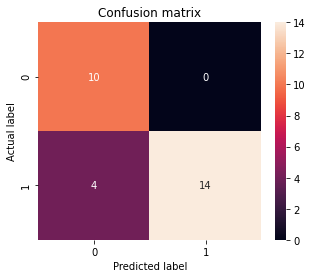

In [122]:
y_pred = model.predict(x_test, batch_size=8)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


predicted_metrics = model.evaluate(x_test, y_test,
                                  batch_size=8, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print(classification_report(y_pred, y_true,
	target_names=lb.classes_))
cm = confusion_matrix(y_pred, y_true)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
